In [50]:
import joblib
import os, time
import lightgbm
import numpy as np
import pandas as pd
import librosa as lr
import seaborn as sns
import scikitplot as skplt
import tensorflow.keras as k
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model


import warnings
warnings.filterwarnings('ignore')

## Загрузка RAVDESS

In [8]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

start = time.time()

data = []

path = 'ravdess'

print('Writing files...')
for subdir, dirs, files in os.walk(path):

    for file in files:
        if file == '.DS_Store':
            pass
        else:
            target = emotions[str(file.split('-')[2])]
            y, sr = lr.load(os.path.join(subdir, file), res_type='kaiser_fast')
            mfccs = np.mean(lr.feature.mfcc(y=y, sr=sr, n_mfcc=30).T, axis=0)
            sample = mfccs, target
            data.append(sample)

end = time.time()
print(f'Writing finished in {end - start} seconds')

X, y = zip(*data)

dataset = pd.DataFrame(X, y)

dataset = dataset.reset_index()
dataset.rename(columns={
    'index': 'target'
}, inplace=True)
dataset = dataset[dataset['target'] != 'calm']
dataset['target'].replace({
    'angry': 0,
    'disgust': 1,
    'fearful': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprised': 6
}, inplace=True)

joblib.dump(dataset, 'r.pkl')

Writing files...
Writing finished in 48.582847118377686 seconds


['r.pkl']

## Загрузка SAVEE

In [9]:
path = 'savee'

data_savee = []

print('Writing files...')
start = time.time()
for i in os.listdir(path):
    target = ''
    if i[-8:-6] == '_a':
        target = 'angry'
    elif i[-8:-6] == '_d':
        target = 'disgust'
    elif i[-8:-6] == '_f':
        target = 'fearful'
    elif i[-8:-6] == '_h':
        target = 'happy'
    elif i[-8:-6] == '_n':
        target = 'neutral'
    elif i[-8:-6] == 'sa':
        target = 'sad'
    elif i[-8:-6] == 'su':
        target = 'surprised'

    y, sr = lr.load(os.path.join(path, i), res_type='kaiser_fast')
    mfccs = np.mean(lr.feature.mfcc(y=y, sr=sr, n_mfcc=30).T, axis=0)
    sample = mfccs, target
    data_savee.append(sample)
end = time.time()

print(f'Writing finished in {end - start} seconds')

X, y = zip(*data_savee)
ds_savee = pd.DataFrame(X, y)
ds_savee = ds_savee.reset_index()
ds_savee.rename(columns={
    'index': 'target'
}, inplace=True)
ds_savee['target'].replace({
    'angry': 0,
    'disgust': 1,
    'fearful': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprised': 6
}, inplace=True)
joblib.dump(ds_savee, 's.pkl')

Writing files...
Writing finished in 15.709449052810669 seconds


['s.pkl']

## Загрузка TESS

In [10]:
path = 'tess'
data_tess = []

start = time.time()
print('Writing files...')
for subdir, dirs, files in os.walk(path):
    for file in files:
        if file == '.DS_Store':
            pass
        else:
            target = file.split('_')[2].split('.')[0]
            y, sr = lr.load(os.path.join(subdir, file), res_type='kaiser_fast')
            mfccs = np.mean(lr.feature.mfcc(y=y, sr=sr, n_mfcc=30).T, axis=0)
            sample = mfccs, target
            data_tess.append(sample)
end = time.time()

print(f'Took {end - start} seconds to write')

X, y = zip(*data_tess)

dataset_tess = pd.DataFrame(X, y)
dataset_tess = dataset_tess.reset_index()
dataset_tess.rename(columns={
    'index': 'target'
}, inplace=True)
dataset_tess['target'].replace({'ps': 'surprised', 'fear': 'fearful'}, inplace=True)
dataset_tess.replace({
    'angry': 0,
    'disgust': 1,
    'fearful': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprised': 6
}, inplace=True)

joblib.dump(dataset_tess, 't.pkl')

Writing files...
Took 70.25495386123657 seconds to write


['t.pkl']

In [11]:
r = joblib.load('r.pkl')
s = joblib.load('s.pkl')
t = joblib.load('t.pkl')
d = r.append(s, ignore_index=True)
data = d.append(t, ignore_index=True)

In [12]:
data

,target,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,-545.244568,38.073475,-8.023163,7.236884,-13.688817,-2.157916,-12.315373,-7.948586,-14.858138,...,-5.148194,0.199227,-2.582171,0.488896,-3.804322,-1.255647,-1.477054,-2.277039,1.629128,3.607785
1,2,-553.611633,41.233486,-9.912664,8.587062,-5.737630,-5.831647,-17.839375,-11.084945,-11.369494,...,-0.452631,0.835115,2.007019,3.959704,1.253125,5.491107,0.736157,1.211208,0.351946,-0.866680
2,2,-393.795807,23.630589,-31.706553,5.434424,-13.875550,-12.362458,-17.879457,-9.511669,-12.548822,...,-0.820805,-3.272198,-2.836839,2.028101,-0.517696,0.939069,-3.411469,-2.542060,-0.170919,0.962250
3,0,-443.760956,37.470089,-12.727585,8.477987,-14.285860,-7.614801,-7.741107,-7.442252,-12.653192,...,2.130092,1.089134,1.541005,3.694799,1.446681,6.036214,1.740135,1.412489,-1.472468,-0.504365
4,1,-628.635376,54.999310,-4.658513,13.789004,-9.365298,2.934855,-13.357954,-6.432891,-10.186466,...,-3.303729,-2.308873,-2.420612,-2.094836,-2.699427,0.585045,-1.338726,0.658216,-1.410033,-2.678679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7323,5,-558.038635,77.208191,25.986273,21.843632,9.312582,15.048077,-15.401534,-5.647860,-13.740882,...,6.385133,-3.970467,-3.299239,-0.996154,-6.564138,2.681046,-2.574730,1.847726,-1.685668,3.346698
7324,5,-542.698364,82.022781,25.764338,23.858538,12.007474,23.895311,-0.630172,-7.165123,-11.655015,...,2.976336,-2.120360,-1.333392,2.724582,-4.031112,1.218586,-3.683059,4.687562,0.297003,5.269110
7325,5,-510.610992,93.520157,18.780354,16.037371,8.915707,15.675911,-16.995647,-9.905157,-11.779231,...,4.898846,-5.591362,-1.983834,-1.127268,-5.159579,1.771178,4.280260,7.705583,7.197507,8.906354
7326,5,-546.745667,102.456856,29.350403,9.353167,5.088076,16.211613,-19.482424,-9.139943,-13.998829,...,0.802646,-1.389408,-2.334331,-1.394641,-1.248525,-2.663252,2.563457,1.157422,-3.017497,4.100055


In [85]:
data.describe()

,target,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
count,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,...,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000,7328.000000
mean,2.995087,-439.849284,66.985383,-1.437385,16.513855,-7.833486,5.320350,-13.515905,-3.228939,-13.808788,...,-0.994893,0.991432,-0.872412,3.680592,1.196336,4.276625,1.795131,3.602649,1.828948,3.257748
std,2.003812,99.658316,24.463403,16.517170,14.930586,12.000898,7.720130,6.719958,7.337237,6.955263,...,5.224310,5.630875,5.546785,7.441786,8.275085,7.178878,6.084845,5.195367,4.777946,4.540259
min,0.000000,-843.170715,-1.007618,-60.927677,-31.823338,-52.020805,-23.409380,-35.136723,-26.590179,-33.572475,...,-12.379154,-9.644827,-10.778439,-7.323341,-12.877155,-6.742919,-10.258218,-7.335911,-9.643845,-8.273466
25%,1.000000,-500.807098,48.472210,-14.280177,5.352139,-15.363681,0.096394,-17.909639,-8.550512,-19.364475,...,-5.026421,-2.419123,-4.252554,-0.644352,-3.332232,-0.232359,-1.790444,0.206266,-1.127659,-0.105813
50%,3.000000,-423.901581,67.230392,-2.640926,15.866012,-7.873140,5.215461,-13.341014,-3.533376,-14.090384,...,-1.431476,0.355690,-2.096395,1.681235,-0.947745,2.427546,0.347631,2.520722,1.002125,2.952967
75%,5.000000,-372.570038,83.736614,11.412264,26.676359,-0.003495,10.749677,-8.993363,2.343270,-8.736699,...,2.326274,3.042227,0.846306,5.221857,2.062229,6.190822,3.113547,5.537399,3.723742,5.941264
max,6.000000,-197.032227,163.119568,47.740650,63.038437,31.014313,26.963272,9.745860,14.860209,8.179226,...,27.525362,39.930077,33.229439,38.224606,37.777588,34.540585,30.576370,31.762383,28.786222,21.857687


## Проверка балансировки классов

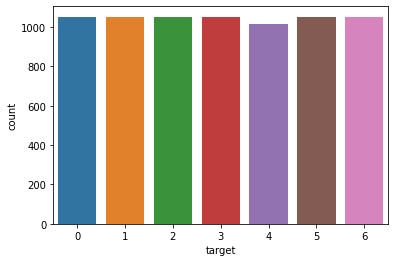

In [14]:
sns.countplot(data['target'])

## Классические ML-алгоритмы

### Случайный лес

In [19]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, max_depth=20, bootstrap=True)

y, X = data['target'], data.drop('target', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
print(classification_report(y_test, random_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       300
           1       0.87      0.87      0.87       332
           2       0.92      0.86      0.89       338
           3       0.92      0.87      0.89       315
           4       0.91      0.95      0.93       301
           5       0.88      0.90      0.89       300
           6       0.89      0.89      0.89       313

    accuracy                           0.89      2199
   macro avg       0.89      0.89      0.89      2199
weighted avg       0.89      0.89      0.89      2199



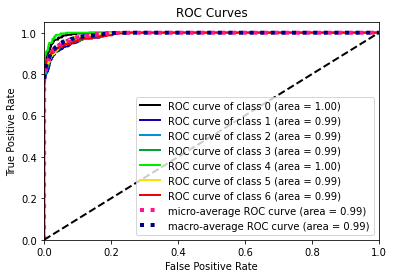

In [27]:
skplt.metrics.plot_roc_curve(y_test, random_forest.predict_proba(X_test))

### Дерево решений

In [30]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(**{
    'max_depth': 5,
    'max_features': 4,
    'splitter': 'best'
})

tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [31]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.34      0.51       300
           1       0.57      0.11      0.18       332
           2       0.64      0.68      0.66       338
           3       0.57      0.48      0.52       315
           4       0.53      0.86      0.66       301
           5       0.83      0.62      0.71       300
           6       0.27      0.59      0.37       313

    accuracy                           0.52      2199
   macro avg       0.63      0.53      0.52      2199
weighted avg       0.62      0.52      0.51      2199



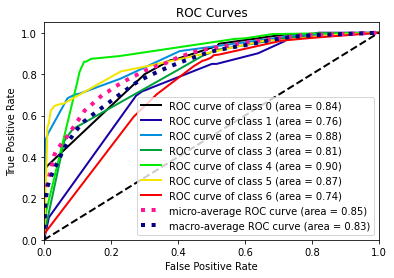

In [32]:
skplt.metrics.plot_roc_curve(y_test, tree.predict_proba(X_test))

### Градиентный бустинг

In [34]:
gboost = lightgbm.LGBMClassifier(**{
    'learning_rate': 0.03,
    'n_estimators': 100,
    'max_depth': 4,
    'subsample': 0.8,
    'gamma': 0.1,
    'colsample_bytree': 0.7
})

gboost.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               gamma=0.1, importance_type='split', learning_rate=0.03,
               max_depth=4, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.8, subsample_for_bin=200000,
               subsample_freq=0)

In [35]:
pd.DataFrame(classification_report(y_test, gboost.predict(X_test), output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.814590,0.893333,0.852146,300.000000
1,0.728723,0.825301,0.774011,332.000000
2,0.910653,0.784024,0.842607,338.000000
3,0.903226,0.800000,0.848485,315.000000
4,0.898990,0.887043,0.892977,301.000000
5,0.782209,0.850000,0.814696,300.000000
6,0.860465,0.827476,0.843648,313.000000
accuracy,0.836744,0.836744,0.836744,0.836744
macro avg,0.842694,0.838168,0.838367,2199.000000
weighted avg,0.842753,0.836744,0.837629,2199.000000


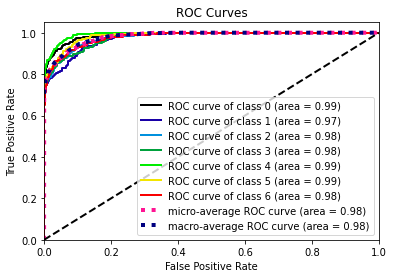

In [36]:
skplt.metrics.plot_roc_curve(y_test, gboost.predict_proba(X_test))

## Нейронные сети

### Сверточная нейросеть

In [55]:
X = np.expand_dims(data.iloc[:, 1:].values, axis=2)
y = k.utils.to_categorical(data.iloc[:, 0].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

inputs = k.Input(shape=(30, 1))
x = k.layers.Conv1D(filters=128, kernel_size=3)(inputs)
x = k.layers.BatchNormalization()(x)
x = k.layers.LeakyReLU()(x)
x = k.layers.Conv1D(filters=64, kernel_size=3)(x)
x = k.layers.LeakyReLU()(x)
x = k.layers.MaxPool1D(pool_size=2)(x)
x = k.layers.Dropout(rate=0.3)(x)
x = k.layers.BatchNormalization()(x)
x = k.layers.Conv1D(filters=32, kernel_size=3)(x)
x = k.layers.LeakyReLU()(x)
x = k.layers.Conv1D(filters=16, kernel_size=3)(x)
x = k.layers.MaxPool1D(pool_size=2)(x)
x = k.layers.Dropout(rate=0.3)(x)

x = k.layers.Flatten()(x)
x = k.layers.Dense(units=7)(x)
outputs = k.layers.Softmax()(x)


model = Model(inputs, outputs, name='cnn_model')
model.compile(optimizer=Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy', 'mae'])

cnn = load_model('cnn.hdf5')
preds_cnn = [x.argmax() for x in cnn.predict(X_test)]
y_test = [x.argmax() for x in y_test]

# model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))
# model.save('cnn.hdf5')

In [56]:
pd.DataFrame(classification_report(y_test, preds_cnn, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.919094,0.946667,0.932677,300.000000
1,0.917889,0.942771,0.930163,332.000000
2,0.976821,0.872781,0.921875,338.000000
3,0.900621,0.920635,0.910518,315.000000
4,0.965278,0.923588,0.943973,301.000000
5,0.885802,0.956667,0.919872,300.000000
6,0.936102,0.936102,0.936102,313.000000
accuracy,0.927694,0.927694,0.927694,0.927694
macro avg,0.928801,0.928459,0.927883,2199.000000
weighted avg,0.929340,0.927694,0.927750,2199.000000


### LSTM 

In [80]:
X = np.expand_dims(data.iloc[:, 1:].values, axis=2)
y = k.utils.to_categorical(data.iloc[:, 0].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

inputs = k.Input(shape=(30, 1))
x = k.layers.BatchNormalization()(inputs)
x = k.layers.LSTM(30, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(x)
x = k.layers.LSTM(30, activation='sigmoid', dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x)
x = k.layers.Flatten()(x)
outputs = k.layers.Dense(7, activation='softmax')(x)

model = Model(inputs, outputs, name='LSTM_model')
model.compile(optimizer=Adam(lr=0.005), loss='categorical_crossentropy', metrics=['accuracy', 'mae'])

rnn = load_model('rnn.hdf5')
preds_rnn = [x.argmax() for x in rnn.predict(X_test)]
y_test = [x.argmax() for x in y_test]

In [83]:
pd.DataFrame(classification_report(y_test, preds_cnn, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.919094,0.946667,0.932677,300.000000
1,0.917889,0.942771,0.930163,332.000000
2,0.976821,0.872781,0.921875,338.000000
3,0.900621,0.920635,0.910518,315.000000
4,0.965278,0.923588,0.943973,301.000000
5,0.885802,0.956667,0.919872,300.000000
6,0.936102,0.936102,0.936102,313.000000
accuracy,0.927694,0.927694,0.927694,0.927694
macro avg,0.928801,0.928459,0.927883,2199.000000
weighted avg,0.929340,0.927694,0.927750,2199.000000


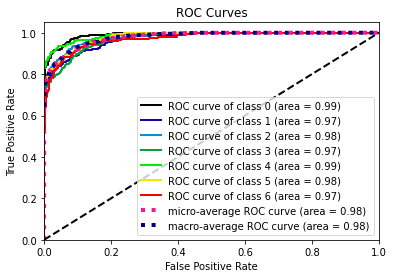

In [84]:
skplt.metrics.plot_roc_curve(y_test, rnn.predict_proba(X_test))

## Прогноз

In [87]:
signal, sr = lr.load('Liza-surprised-v3.wav', res_type='kaiser_fast')
mfccs = np.mean(lr.feature.mfcc(y=signal, sr=sr, n_mfcc=30).T, axis=0)
sample = np.expand_dims(mfccs, axis=1).reshape(1, 30, 1)
cnn.predict(sample).argmax()

6